In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [4]:
#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)

In [5]:
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [6]:
from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

In [7]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
for sid in major_structure_ids:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])


In [8]:
def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

In [9]:
msvd = msvds[sid]
cres = creline[sid]
eminors = experiments_minor_structures[sid]
# def get_cre_similarity(msvd, cres,eminors):

#     #sid = 512
#     data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns = np.append(['cre','injsum'],colnames))
#     data_melted = pd.melt(data_merged, id_vars=['cre','injsum'])
#     data_melted = data_melted.astype({'value': np.float64})
#     means = data_melted.groupby(by=['variable', 'cre','injsum'])['value'].mean().reset_index()
#     means = means.astype({'value': np.float64})
#     means_cast = pd.pivot_table(means, index = ['injsum','cre'], columns = 'variable')
#     means_cast.columns = means_cast.columns.get_level_values(1)
#     #pairwise_distances(means_cast)
#     cs = np.asarray(list(means_cast.index))
    
#     return(means_cast,cs)
def get_cre_similarity(msvd, cres,eminors,colnames):

    #sid = 512
#     data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns = np.append(['cre','injsum'],colnames))
#     data_melted = pd.melt(data_merged, id_vars=['cre','injsum'])
#     data_melted = data_melted.astype({'value': np.float64})
#     means = data_melted.groupby(by=['variable', 'cre','injsum'])['value'].mean().reset_index()
#     means = means.astype({'value': np.float64})
#     means_cast = pd.pivot_table(means, index = ['injsum','cre'], columns = 'variable')
#     means_cast.columns = means_cast.columns.get_level_values(1)
#     #pairwise_distances(means_cast)
#     cs = np.asarray(list(means_cast.index))
    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

In [10]:
def get_mean_dist(means_cast):
    cs = np.asarray(list(means_cast.index))
    results = {}
    reg = np.unique(cs[:,0])
    nreg = len(reg)
    for i in range(nreg):
        results[reg[i]] = {}
        reg_cre_ind = np.where(cs[:,0] == reg[i])[0]
        for j in range(len(reg_cre_ind)):
            for k in range(len(reg_cre_ind)):
                results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])] = np.linalg.norm(means_cast.iloc[reg_cre_ind[j]] - means_cast.iloc[reg_cre_ind[k]])
    return(results)

In [11]:
def get_cre_dist(results, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            t= tuple([cres[i], cres[j]])
            if np.isin(t, rkeys).all():
                credist[i,j]  = results[eminors[i]][t]
    return(credist)

\begin{eqnarray*}
\mu_n = \frac{1}{n} \sum_{i = 1}^n x_i = \frac{1}{n} (\sum_{i = 1}^{n-1} x_i + x_n) \\
= \frac{1}{n} (\sum_{i = 1}^{n-1} x_i)  + \frac{1}{n}  x_n \\
\frac{n-1}{n} \mu_{n-1} + \frac{1}{n}  x_n \\
\rightarrow \frac{n-1}{n} \mu_{n-1}  = \mu_n - \frac{1}{n}  x_n \\
\rightarrow \mu_{n-1} = \frac{n}{n-1} (\mu_n - \frac{1}{n}  x_n) 
\end{eqnarray*}

In [14]:
import math

def get_cre_dist_cv(msvd, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([eminors[i],cres[i]])]
        ncr = len(np.where(cres == cres[i])[0])
        meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[cres[j]]
            #t= tuple([cres[i], cres[j]])
            if np.isin(t, rkeys).all():
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)
    return(credist)

def get_loss_surface(msvd,cre_dist, fraction):
    #ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = msvd.centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
    ngp = goodpairs.shape[0]
    centroids = msvd.centroids
    projs = msvd.reg_proj_vcount_norm_renorm
    ds2 = np.zeros(ngp)
    ls2 = np.zeros(ngp)
    for i in range(ngp):
        print(i)
        ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        
    cs2 = cs[np.where(~np.isnan(cs))]    
    #ds2 = ds[np.where(~np.isnan(cs))]
    #
    source2 = source[np.where(~np.isnan(cs.flatten()))]
    target2 = target[np.where(~np.isnan(cs.flatten()))]

    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)

    ds2 = ds2 / dsnorm
    cs2 = cs2 / csnorm
    #ls2 = ls[np.where(~np.isnan(cs))]

    dc = np.asarray([ds2,cs2,ls2]).transpose()
    #ids = np.linspace(0,35, 36, dtype = int), 36)
    
    qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
    #return(qqq)
# xs = np.linspace(0, dc[:,0].max(), 100)
# ys = np.linspace(0, dc[:,1].max(), 100)
# preds = np.empty((100,100))
# for x in range(100):
#     for y in range(100):
#         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
    return(qqq)
# xs = np.linspace(0, dc[:,0].max(), 100)
# ys = np.linspace(0, dc[:,1].max(), 100)
# preds = np.empty((100,100))
# for x in range(100):
#     for y in range(100):
#         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))

In [15]:
def get_smoothed_losses(msvd, qqq, cre_dist):
    ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    ds2 = ds[np.where(~np.isnan(cs))]
    cs2 = cs[np.where(~np.isnan(cs))]
    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)
    
    ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = ds.shape[0]
    bbbb = np.asarray(np.where(~np.isnan(cs))).transpose()
    smoothedlosses = np.empty((nsamp,nsamp))
    smoothedlosses[:] = np.nan
    for i in range(bbbb.shape[0]):
        ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
        di = ds[bbbb[i,0], bbbb[i,1]] / dsnorm
        smoothedlosses[bbbb[i,0], bbbb[i,1]] = qqq.predict(np.asarray([[ci, di]]))
    return(smoothedlosses)

In [16]:
def get_cre_dist_cv(msvd, means_cast, eminors,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         #get mean of all points sharing cre line and minor structure with this one (but not including)
#         meani = means_cast.loc[tuple([eminors[i],cres[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
#         meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
#         for j in range(nsamp):
#             meanj = means_cast.loc[cres[j]]
#             #t= tuple([cres[i], cres[j]])
#             if np.isin(t, rkeys).all():
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
        ncr = len(np.where(cres == cres[i])[0])
        meanloocvi = meani
        meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

In [ ]:
sls = {}

In [36]:

frac_learn = np.ones(12)
frac_learn[4] = .01
m = 0
#for m in range(1):
sid = major_structure_ids[m]
for sid in np.asarray(major_structure_ids)[:1]:#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    msvd = msvds[sid]
    cres = creline[sid]
    eminors = experiments_minor_structures[sid]
    means_cast, cs = get_cre_similarity(msvd, cres,eminors, colnames)
    #mean_dist = get_mean_dist(means_cast)
    #cre_dist = get_cre_dist(mean_dist, eminors,cres)
    cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)
    sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

512
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [37]:
#     #def get_loss_surface(msvd,cre_dist, fraction):
#     fraction  = .01
#     cre_dist = cre_dist2
#     #ds = pairwise_distances(msvd.centroids)**2
#     cs = cre_dist
#     #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
#     nsamp = msvd.centroids.shape[0]
#     #need source and target color
#     source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
#     target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
#     goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
#     ngp = goodpairs.shape[0]
#     centroids = msvd.centroids
#     projs = msvd.reg_proj_vcount_norm_renorm
#     ds2 = np.zeros(ngp)
#     ls2 = np.zeros(ngp)
#     for i in range(ngp):
#         print(i)
#         ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
#         ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        
#     cs2 = cs[np.where(~np.isnan(cs))]    
#     #ds2 = ds[np.where(~np.isnan(cs))]
#     #
#     source2 = source[np.where(~np.isnan(cs.flatten()))]
#     target2 = target[np.where(~np.isnan(cs.flatten()))]

#     dsnorm  = np.linalg.norm(ds2)
#     csnorm = np.linalg.norm(cs2)

#     ds2 = ds2 / dsnorm
#     cs2 = cs2 / csnorm

#     dc = np.asarray([ds2,cs2,ls2]).transpose()


In [38]:
# qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)

In [39]:
#randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))

In [40]:
#qqq.fit(dc[:,:2][randos], dc[:,2:][randos])

In [41]:
#sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

Text(0.5, 0, 'Projection distance predicted')

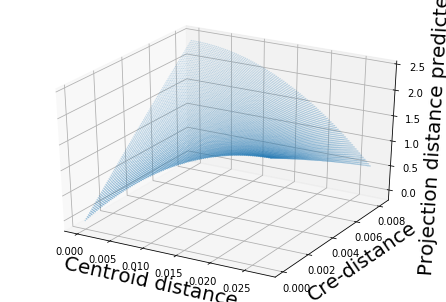

In [27]:
xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [42]:
#help(KernelRidge)

In [43]:
#    qqq = get_loss_surface(msvd, cre_dist2,frac_learn[m])
    

In [44]:
#sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

In [47]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[:1]:
 
    
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[:1]:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_leaf2ormore = get_eval_indices(indices_leaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_leaf2ormore, true_ind = eval_indices_leaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(13, 5, 36, 577)
0


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in exp
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


In [46]:
sls.keys()

dict_keys([512])

In [48]:
meanloss_nw_leaf_leaf2

array([1.15599565])

In [35]:
meanloss_nw_leaf_leaf2[[4,7,2,1,10,9,11,3,5,8,6,0]]

array([0.27891222, 0.48520206, 0.34344099, 0.44434151, 0.44660119,
       0.23022645, 0.33963109, 0.31162283, 0.79450517, 0.15801227,
       0.20941519, 1.15599565])

In [147]:
np.concatenate([meanloss_nw_leaf_leaf2, np.zeros(8)])[[4,7,2,1,10,9,11,3,5,8,6,0]]

array([0.        , 0.        , 0.31709592, 0.44434151, 0.        ,
       0.        , 0.        , 0.24324091, 0.        , 0.        ,
       0.        , 0.82904618])

In [ ]:
#is this all from not having the positive mean effect?? or from not merging ipsi and contra?

In [49]:
saved = np.asarray([0.27891222, 0.48520206, 0.34344099, 0.44434151, 0.44660119,
       0.23022645, 0.33963109, 0.31162283, 0.79450517, 0.15801227,
       0.20941519, 1.15599565])

In [51]:
bbbb = pd.DataFrame(saved)

In [52]:
bbbb.to_clipboard()

In [83]:
ss = np.append(['cre','injsum'],colnames)
ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
colns = np.vstack([ns,ss]).transpose()
clns = list(zip(*colns.transpose()))
clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns= clnsmi)
data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
data_melted = data_melted.astype({'value': np.float64})
means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
means = means.astype({'value': np.float64})
means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
cs = np.asarray(list(means_cast.index))

In [87]:
data_merged
#data_merged.add_prefix(ns)

first                                    ipsi                            \
second                cre injsum          FRP          MOp          MOs   
0                C57BL/6J     IP  0.000473149  2.87112e-06    0.0365323   
1          Pcp2-Cre_GN135     AN   0.00871041  3.23832e-05  1.58082e-08   
2           Gad2-IRES-Cre    CUL    0.0706092  0.000712335  1.91642e-05   
3                C57BL/6J    PRM    0.0620111            0            0   
4          Pcp2-Cre_GN135     AN   0.00309536            0            0   
5         Gabra6-IRES-Cre    SIM    0.0161942  2.85744e-05            0   
6         Htr2a-Cre_KM207     DN  1.06518e-07            0   0.00505787   
7       Ppp1r17-Cre_NL146    SIM    0.0760557  4.08898e-07            0   
8           Grm2-Cre_MR90    CUL    0.0279328   0.00400827            0   
9                C57BL/6J   CENT    0.0331962     0.013486            0   
10          Gad2-IRES-Cre    NOD            0            0            0   
11               C57BL/6J    CUL   0.00120168  0.000356826  7.08839e-05   
12        Gpr26-Cre_KO250     IP   0.00413003  4.24763e-07   0.00861616   
13        Gabra6-IRES-Cre     AN    0.0194599            0            0   
14           Nos1-CreERT2    SIM    0.0374721  0.000217075   0.00246204   
15         Pcp2-Cre_GN135    SIM   0.00509138  0.000169073  4.25849e-05   
16        Ntsr1-Cre_GN220     IP   0.00884835  5.79942e-05    0.0181221   
17               C57BL/6J   CENT    0.0016572  0.000336298  2.67689e-05   
18         Pvalb-IRES-Cre     AN   0.00312427  2.09801e-05   0.00176919   
19         Pcp2-Cre_GN135   CENT    0.0173734   0.00455936  0.000130699   
20        Efr3a-Cre_NO108    CUL     0.023401   0.00205055            0   
21               C57BL/6J    CUL     0.011766    0.0181944            0   
22               C57BL/6J    PYR   0.00267367            0            0   
23       Slc17a6-IRES-Cre    CUL   0.00793691  8.01839e-05            0   
24               C57BL/6J    PFL     0.174737   0.00233402  6.72116e-05   
25              Grik4-Cre    PFL            0  5.25323e-05  3.93792e-05   
26        Gabra6-IRES-Cre    CUL   0.00404571   0.00149091            0   
27               C57BL/6J     AN   0.00266806            0    0.0094458   
28       Slc17a6-IRES-Cre     DN    0.0824177  3.10516e-05   0.00108052   
29               C57BL/6J     AN   0.00868148  7.42878e-05  0.000155696   
30               C57BL/6J    SIM    0.0396983  8.25278e-06   1.7271e-05   
31      Ppp1r17-Cre_NL146    SIM   0.00257506   0.00327622            0   
32         Scnn1a-Tg3-Cre    CUL     0.124711    0.0763545  0.000203508   
33          Grm2-Cre_MR90     AN    0.0953225            0    0.0140276   
34         Pvalb-IRES-Cre    CUL  0.000900243    0.0034944  3.23944e-05   
35               C57BL/6J     FN  0.000681195  9.41644e-06  0.000288931   

first                                                                    ...  \
second        SSp-n      SSp-bfd       SSp-ll        SSp-m       SSp-ul  ...   
0         0.0019443            0   0.00231316  7.46198e-06            0  ...   
1        4.9642e-06            0   0.00215774  3.12761e-05  3.84829e-08  ...   
2                 0            0    0.0907251            0   0.00238974  ...   
3       0.000129869            0  0.000427649  0.000136986            0  ...   
4                 0            0    0.0014072   5.1267e-05            0  ...   
5        0.00170188            0   0.00357033  5.57651e-05            0  ...   
6         0.0221573            0            0            0            0  ...   
7       0.000826797            0    0.0119997   0.00168481            0  ...   
8       2.35997e-05            0    0.0545159  8.80969e-05  0.000361967  ...   
9                 0            0   0.00100081   2.0083e-06            0  ...   
10                0            0            0            0            0  ...   
11                0            0   0.00496009   0.00022845            0  ...   
12                0          

In [117]:
cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [63]:
#data_merged

In [29]:
#means_cast

In [19]:
#     #sid = 512
#     #data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns = np.append(['cre','injsum'],colnames))
#     data_melted = pd.melt(data_merged, id_vars=['cre','injsum'])
#     data_melted = data_melted.astype({'value': np.float64})
#     means = data_melted.groupby(by=['variable', 'cre','injsum'])['value'].mean().reset_index()
#     means = means.astype({'value': np.float64})
#     means_cast = pd.pivot_table(means, index = ['injsum','cre'], columns = 'variable')
#     means_cast.columns = means_cast.columns.get_level_values(1)
#     #pairwise_distances(means_cast)
#     cs = np.asarray(list(means_cast.index))


In [102]:
#colnames.shape

In [103]:
#data_merged.shape

In [104]:
#data_melted

In [28]:
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([eminors[i],cres[i]])]
        ncr = len(np.where(cres == cres[i])[0])
        meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[cres[j]]
            #t= tuple([cres[i], cres[j]])
            if np.isin(t, rkeys).all():
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)


0


ValueError: operands could not be broadcast together with shapes (291,) (577,) 

In [29]:
meani.shape

(291,)

(31, 291)

In [23]:
means_cast.loc[tuple(['SIM', 'C57BL/6J'])]

variable
AAA      0.000000
ACAd     0.004772
ACAv     0.003865
ACB      0.000000
ACVII    0.000000
           ...   
VTN      0.000000
XII      0.005177
ZI       0.001667
x        0.000029
y        0.000178
Name: (SIM, C57BL/6J), Length: 291, dtype: float64

In [31]:
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns = np.append(['cre','injsum'],colnames))
    data_melted = pd.melt(data_merged, id_vars=['cre','injsum'])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['variable', 'cre','injsum'])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = ['injsum','cre'], columns = 'variable')
    means_cast.columns = means_cast.columns.get_level_values(1)
    #pairwise_distances(means_cast)
    cs = np.asarray(list(means_cast.index))


In [ ]:
data_merged.shape

In [ ]:
means.shape

In [34]:
data_merged.shape

(36, 579)

In [33]:
means_cast

variable                           AAA      ACAd      ACAv           ACB  \
injsum cre                                                                 
AN     C57BL/6J           1.102997e-06  0.001249  0.000276  1.901200e-05   
       Gabra6-IRES-Cre    0.000000e+00  0.000024  0.000475  0.000000e+00   
       Grm2-Cre_MR90      0.000000e+00  0.000851  0.000125  0.000000e+00   
       Pcp2-Cre_GN135     1.954919e-06  0.000190  0.000180  0.000000e+00   
       Pvalb-IRES-Cre     1.471474e-05  0.001251  0.000122  6.879612e-07   
CENT   C57BL/6J           0.000000e+00  0.000066  0.000240  0.000000e+00   
       Pcp2-Cre_GN135     4.459760e-04  0.004609  0.000323  1.606522e-04   
CUL    C57BL/6J           0.000000e+00  0.001001  0.000221  0.000000e+00   
       Efr3a-Cre_NO108    7.546240e-03  0.000188  0.000801  1.564424e-07   
       Gabra6-IRES-Cre    0.000000e+00  0.000002  0.000095  6.082090e-05   
       Gad2-IRES-Cre      2.108764e-04  0.004153  0.001770  0.000000e+00   
       Grm2-Cre_MR90      0.000000e+00  0.024131  0.002165  1.387202e-03   
       Pvalb-IRES-Cre     3.899838e-08  0.000620  0.000025  0.000000e+00   
       Scnn1a-Tg3-Cre     3.762295e-02  0.034973  0.001631  7.334833e-05   
       Slc17a6-IRES-Cre   0.000000e+00  0.000503  0.000567  0.000000e+00   
DN     Htr2a-Cre_KM207    0.000000e+00  0.000021  0.000016  7.032220e-04   
       Slc17a6-IRES-Cre   0.000000e+00  0.000071  0.001818  1.373201e-03   
FN     C57BL/6J           0.000000e+00  0.000446  0.000095  4.087071e-04   
IP     C57BL/6J           6.205964e-06  0.000040  0.000191  1.309091e-04   
       Gpr26-Cre_KO250    0.000000e+00  0.000104  0.000451  3.051877e-03   
       Ntsr1-Cre_GN220    4.656217e-05  0.001738  0.000420  1.916513e-03   
NOD    Gad2-IRES-Cre      0.000000e+00  0.000028  0.000022  0.000000e+00   
PFL    C57BL/6J           0.000000e+00  0.029178  0.004907  7.370082e-03   
       Grik4-Cre          0.000000e+00  0.000128  0.000000  0.000000e+00   
PRM    C57BL/6J           9.421474e-05  0.000068  0.000242  0.000000e+00   
PYR    C57BL/6J           0.000000e+00  0.000002  0.000022  0.000000e+00   
SIM    C57BL/6J           0.000000e+00  0.004772  0.003865  0.000000e+00   
       Gabra6-IRES-Cre    0.000000e+00  0.005144  0.001163  0.000000e+00   
       Nos1-CreERT2       0.000000e+00  0.000107  0.001306  0.000000e+00   
       Pcp2-Cre_GN135     0.000000e+00  0.000418  0.000030  0.000000e+00   
       Ppp1r17-Cre_NL146  0.000000e+00  0.000111  0.000461  0.000000e+00   

variable                     ACVII            AD       ADP           AHN  \
injsum cre                                                                 
AN     C57BL/6J           0.000019  0.000000e+00  0.000554  7.612922e-04   
       Gabra6-IRES-Cre    0.000000  0.000000e+00  0.000020  0.000000e+00   
       Grm2-Cre_MR90      0.000523  0.000000e+00  0.000000  2.721355e-04   
       Pcp2-Cre_GN135     0.000001  0.000000e+00  0.000050  1.205950e-04   
       Pvalb-IRES-Cre     0.000580  0.000000e+00  0.001323  1.508310e-05   
CENT   C57BL/6J           0.000101  0.000000e+00  0.001272  1.582394e-04   
       Pcp2-Cre_GN135     0.001917  4.302361e-06  0.001532  7.317556e-05   
CUL    C57BL/6J           0.000214  0.000000e+00  0.000224  3.868335e-05   
       Efr3a-Cre_NO108    0.000000  3.106962e-04  0.000093  0.000000e+00   
       Gabra6-IRES-Cre    0.000000  1.297325e-04  0.000103  8.112233e-04   
       Gad2-IRES-Cre      0.000138  1.235436e-05  0.000250  9.759528e-04   
       Grm2-Cre_MR90      0.002036  0.000000e+00  0.015162  1.283284e-08   
       Pvalb-IRES-Cre     0.000015  0.000000e+00  0.000030  3.822190e-06   
       Scnn1a-Tg3-Cre     0.002705  4.703251e-07  0.004061  9.610156e-04   
       Slc17a6-IRES-Cre   0.000000  0.000000e+00  0.000283  2.081911e-05   
DN     Htr2a-Cre_KM207    0.000087  0.000000e+00  0.000000  0.000000e+00   
       Slc17a6-IRES-Cre   0.000013  1.312906e-02  0.003405  1.098523e-02   
FN     C57BL/6J           0.059913  3.081302e-0